In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!pip install scikit-cuda
import skcuda.linalg as linalg

     |████████████████████████████████| 114 kB 4.2 MB/s 
     |████████████████████████████████| 1.7 MB 30.4 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 75 kB 4.9 MB/s 
     |████████████████████████████████| 66 kB 5.5 MB/s 
  Created wheel for pycuda: filename=pycuda-2021.1-cp37-cp37m-linux_x86_64.whl size=627370 sha256=d43663d561a56c81c3ab91bc264723776c8af31a183969bad37d788dd0d0c691
  Stored in directory: /root/.cache/pip/wheels/c4/ef/49/dc6a5feb8d980b37c83d465ecab24949a6aa19458522a9e001
  Created wheel for pytools: filename=pytools-2021.2.9-py2.py3-none-any.whl size=62370 sha256=2fb0d059f39aae8cdda9a7f7ed79b951b3307fb2b141f8da1ebaf3044bc14b20
  Stored in directory: /root/.cache/pip/wheels/41/b9/6e/94bb014f6484b15ec77e7877f3a227609481ffd98db364504d
Successfully built pycuda pytools


/usr/local/lib/python3.7/dist-packages/skcuda/cublas.py:284: UserWarning: creating CUBLAS context to get version number
  warnings.warn('creating CUBLAS context to get version number')


In [2]:
import torchvision.models as models
import torch 
import torch.nn as nn
import logging
resnet = models.resnet18(pretrained=True)
alexnet=models.alexnet(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

In [3]:
import numpy as np
import h5py
import torch
import matplotlib.pyplot as plt

def convert_gray2rgb(image):
    batch,width, height = image.shape
    out = np.empty((batch,width, height, 3), dtype=np.uint8)
    out[:,:, :, 0] = image
    out[:,:, :, 1] = image
    out[:,:, :, 2] = image
    return out
    
f = h5py.File('/content/gdrive/MyDrive/npc_v4_data.h5','r')
data = f['images/naturalistic'][:]
data.shape

(640, 299, 299)

In [ ]:
test_data=f['images/naturalistic'][0:2,:]
test_data.shape

(2, 299, 299)

In [6]:
perm_tensor=torch.tensor(convert_gray2rgb(data)).permute(0,3,1,2)
perm_tensor.shape
test_perm_tensor=perm_tensor[0:2,:]
test_perm_tensor.shape

torch.Size([2, 3, 299, 299])

In [4]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

In [7]:
#alexnet
import torch.nn.functional as F
x1=F.interpolate(perm_tensor,(256,256))
alexnet.features[6].register_forward_hook(get_activation('features[6]'))
output=alexnet(x1.divide(255))
activation['features[6]'].reshape(640,-1).shape
input=activation['features[6]']
input=input.permute(0,2,3,1)
print(input.shape)

torch.Size([640, 15, 15, 384])


In [8]:
n1 = f.get('neural/naturalistic/monkey_m/ohp/session_1')[:]
# target=np.mean(n1, axis=0)[:,0]
target=np.mean(n1, axis=0)
target=torch.tensor(target)
target.shape


torch.Size([640, 39])

In [24]:
torch.cuda.is_available()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [10]:
from sklearn.model_selection import KFold
from sklearn.linear_model import Ridge
from scipy.stats.stats import pearsonr
from sklearn.decomposition import PCA
seed=10
pca=PCA(random_state=seed)
# array=np.asfortranarray(a.reshape(640,-1))
# X_gpu=gpuarray.to_gpu(array)
# natural_x_pca = pca.fit_transform(X_gpu)
natural_x_pca = pca.fit_transform(torch.tensor(input).cpu().detach().reshape(target.shape[0],-1))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.


In [19]:

natural_prediction= np.empty((target.shape[0],target.shape[1]), dtype=object)
kfold = KFold(n_splits=5, shuffle=True,random_state=seed)
for fold, (train_ids, test_ids) in enumerate(kfold.split(natural_x_pca)):
  clf = Ridge(random_state=seed)
  clf.fit((natural_x_pca)[train_ids],target[train_ids])
  start=fold*10
  end=((fold+1)*10)
  natural_prediction[test_ids]=clf.predict((natural_x_pca)[test_ids])
natural_corr_array= np.array([pearsonr(natural_prediction[:, i], target[:, i])[0] for i in range(natural_prediction.shape[-1])])
print('linear regression score: '+str(np.median(natural_corr_array)))

linear regression score: 0.7966038334029952


In [22]:
import torch
import h5py
# import sys
# sys.path.insert(1,'/Users/apple/Documents/u2_winter_term/comp396/cubemap')
from basemapper import BaseMapper
import numpy as np
import torch
from torch.autograd import Variable
import torch.nn as nn
import pdb
import torch.nn.functional as F

np.random.seed(123)
npa = np.array

class Mapper(BaseMapper):
    def __init__(self, graph=None, num_neurons=39, batch_size=50, init_lr=0.01,
               ls=0, ld=0, tol=1e-2, max_epochs=10, map_type='separable', inits=None,input_ph=None,target_ph=None,
               log_rate=100, decay_rate=200, gpu_options=None):
        """
        Mapping function class.
        :param graph: tensorflow graph to build the mapping function with
        :param num_neurons: number of neurons (response variable) to predict
        :param batch_size: batch size
        :param init_lr: initial learning rate
        :param ls: regularization coefficient for spatial parameters
        :param ld: regularization coefficient for depth parameters
        :param tol: tolerance - stops the optimization if reaches below tol
        :param max_epochs: maximum number of epochs to train
        :param map_type: type of mapping function ('linreg', 'separable')
        :param inits: initial values for the mapping function parameters. A dictionary containing
                    any of the following keys ['s_w', 'd_w', 'bias']
        :param log_rate: rate of logging the loss values
        :param decay_rate: rate of decay for learning rate (#epochs)
        """
        super(Mapper, self).__init__(graph=graph, num_neurons=num_neurons, batch_size=batch_size, init_lr=init_lr,
                                    ls=ls, ld=ld, tol=tol, max_epochs=max_epochs, map_type=map_type, inits=inits,
                                    input_ph=input_ph,
                                     #target_ph=target_ph,
                                     log_rate=log_rate, decay_rate=decay_rate, gpu_options=gpu_options)   
        #input_shape = self._input_ph.shape
#         if self._input_ph is None:

#             input_shape = torch.Size([640, 384, 15, 15])
#         else:
    def _make_separable_map(self,X):
        input_shape = X.shape
        if self._inits is None:
            self.s_w=torch.randn((1, input_shape[1], input_shape[2], 1, self._num_neurons), dtype=torch.float,requires_grad=True,device=device) 
            self.d_w=torch.randn(((1, input_shape[-1], self._num_neurons)), dtype=torch.float,requires_grad=True,device=device) 
            self.bias=torch.randn(((1, self._num_neurons)), dtype=torch.float,requires_grad=True,device=device)
        else:
            if 's_w' in self._inits:
                self.s_w=Variable(torch.from_numpy(self._inits['s_w'].reshape((1, input_shape[1], input_shape[2], 1, self._num_neurons)),dtype=torch.float), requires_grad=True)
            else:
                self.s_w=Variable(torch.from_numpy(np.random.randn(1, input_shape[1], input_shape[2], 1, self._num_neurons),dtype=torch.float), requires_grad=True)
            if 'd_w' in self._inits:
                self.d_w=Variable(torch.from_numpy(self._inits['d_w'].reshape(1, input_shape[-1], self._num_neurons),dtype=torch.float), requires_grad=True)
            else:
                self.d_w = Variable(torch.from_numpy(np.random.randn(1, input_shape[-1], self._num_neurons),dtype=torch.float), requires_grad=True)
            if 'bias' in self._inits:
                self.bias=Variable(torch.from_numpy(self._inits['bias'].reshape(1, self._num_neurons),dtype=torch.float), requires_grad=True)
            else:
                self.bias = Variable(torch.from_numpy(np.zeros((1, self._num_neurons),dtype=torch.float)), requires_grad=True)
    
    def _make_loss(self,Y):
        #self._s_vars,self._d_vars,self._biases=self.forward()
        #self._predictions=self.forward()
        self._target_ph=Y
        self.l2_error=torch.norm(self._predictions - self._target_ph,p=2)
        if self._map_type =='separable':
            laplace_filter=torch.from_numpy(np.array([0, -1, 0, -1, 4, -1, 0, -1, 0],dtype=np.float).reshape((1,1,3,3))).to(device)
            laplace_filter=laplace_filter.type(torch.cuda.FloatTensor)
            # laplace_filter=laplace_filter.type(torch.FloatTensor)
            conv =nn.Conv2d(1, 1, kernel_size=1,bias=False,padding="same").to(device)
            conv.weight = torch.nn.Parameter(laplace_filter)
            # torch.nn.Parameter( torch.FloatTensor(7, 32, 32, device="cuda") )
            conv.requires_grad_(False)
            laplace_loss=self._l2_loss(conv(torch.squeeze(self.s_w.permute(4, 3, 1, 2, 0),4)))
            l2_loss_s = self._l2_loss(self.s_w.permute(4, 3, 1, 2, 0))
            l2_loss_d = self._l2_loss(self.d_w.permute(2, 1, 0))
            self.reg_loss=self._ls*laplace_loss+self._ld*(l2_loss_s+l2_loss_d)
            self._total_loss = self.l2_error + self.reg_loss
            return self._total_loss

    def forward(self,X,Y):
        self.predict(X)
        loss=self._make_loss(Y)
        self._is_initialized = True
        return loss
    def fit(self, X, Y):
        self._make_separable_map(X)
        # print(self.s_w)
        # optimizer = SGD( [self.s_w,self.d_w,self.bias],lr=self._lr , momentum=0.9)
        optimizer = Adam( [self.s_w,self.d_w,self.bias],lr=self._lr )
        for e in range(self._max_epochs):
            for counter, batch in enumerate(self._iterate_minibatches(X, Y, batchsize=self._batch_size, shuffle=True)):                 
                optimizer.zero_grad()
                # print(batch[0].shape,batch[1].shape)
                self.forward(batch[0],batch[1])
                # pdb.set_trace()
                
                self._total_loss.backward()
                
                optimizer.step()
            if (e % self._log_rate == 0) or (e == self._max_epochs - 1):
              print('Epoch: %d, Err Loss: %.2f, Reg Loss: %.2f' % (e + 1, self.l2_error, self.reg_loss))  
            if e % self._decay_rate == 0 and e != 0:
              self._lr /= 10.
            if self._total_loss < self._tol:
              print('Converged.')
              break
              
    def predict(self,X):
        # self._input_ph=X
        
        out=self.s_w*X.unsqueeze(-1)
        out=torch.sum(out,(1,2))
        out=out*self.d_w
        out=torch.sum(out,1)+self.bias
        self._predictions=out
        
#         print(out)
        return out

0
Epoch: 1, Err Loss: 2603.15, Reg Loss: 331163.66
Epoch: 11, Err Loss: 232.90, Reg Loss: 472.92
Epoch: 21, Err Loss: 82.84, Reg Loss: 80.61
Epoch: 31, Err Loss: 24.35, Reg Loss: 21.38
Epoch: 41, Err Loss: 13.31, Reg Loss: 7.03
Epoch: 51, Err Loss: 10.30, Reg Loss: 4.03
Epoch: 61, Err Loss: 9.01, Reg Loss: 3.38
Epoch: 71, Err Loss: 9.53, Reg Loss: 3.29
Epoch: 80, Err Loss: 9.00, Reg Loss: 3.21
1
Epoch: 1, Err Loss: 2285.35, Reg Loss: 326212.91
Epoch: 11, Err Loss: 231.84, Reg Loss: 567.04
Epoch: 21, Err Loss: 89.40, Reg Loss: 105.47
Epoch: 31, Err Loss: 36.00, Reg Loss: 29.91
Epoch: 41, Err Loss: 14.86, Reg Loss: 9.79
Epoch: 51, Err Loss: 10.34, Reg Loss: 4.35
Epoch: 61, Err Loss: 8.47, Reg Loss: 3.23
Epoch: 71, Err Loss: 9.15, Reg Loss: 3.23
Epoch: 80, Err Loss: 9.50, Reg Loss: 3.19
2
Epoch: 1, Err Loss: 2271.05, Reg Loss: 324155.22
Epoch: 11, Err Loss: 231.03, Reg Loss: 502.57
Epoch: 21, Err Loss: 99.37, Reg Loss: 116.27
Epoch: 31, Err Loss: 37.57, Reg Loss: 33.97
Epoch: 41, Err Loss

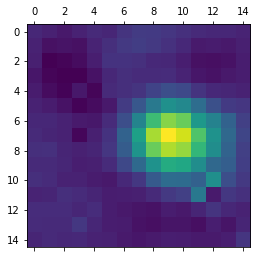

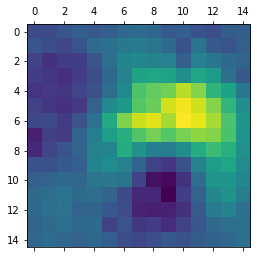

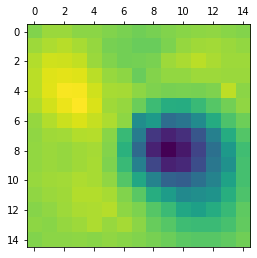

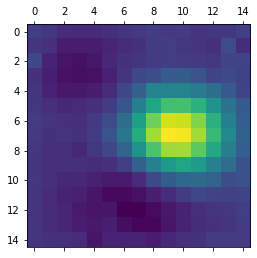

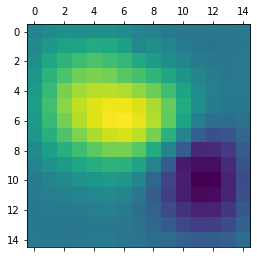

In [26]:
from sklearn.model_selection import KFold
from sklearn.linear_model import Ridge
from scipy.stats.stats import pearsonr
from torch.optim import SGD
from torch.optim import Adam
import matplotlib.pyplot as plt

# Define the K-fold Cross Validator
kfold = KFold(n_splits=5, shuffle=True)
num_neuron=n1.shape[2]
convmap_corr=[]

#for n in range(num_neuron):
prediction= np.empty((640,39), dtype=object)
for fold, (train_ids, test_ids) in enumerate(kfold.split(input)):
  print(fold)
  mapper=Mapper(graph=None, max_epochs=80
                , tol=0.1,ls=1000,ld=1,
                  init_lr=1e-1, batch_size=30, num_neurons=39,
                  map_type='separable', inits=None, decay_rate=10, log_rate=10)

  mapper.fit(input[train_ids,:].to(device),target[train_ids,:].to(device))
  plt.matshow((torch.squeeze(mapper.s_w.cpu().detach()).permute(2,0,1))[1])
  preds=(mapper.predict(input[test_ids,:].to(device))).cpu().detach().numpy()
  prediction[test_ids]=preds
scores = np.array([pearsonr(prediction[:, i], target[:, i])[0] for i in range(prediction.shape[-1])])
print('convmap score: '+ str(np.median(scores)))

In [ ]:
# helper function for grid search
def convmap_function(_ls,_ld,_lr,_epoch,_batch):
  # Define the K-fold Cross Validator
  kfold = KFold(n_splits=5, shuffle=True)
  num_neuron=n1.shape[2]
  convmap_corr=[]

  #for n in range(num_neuron):
  prediction= np.empty((640,39), dtype=object)
  for fold, (train_ids, test_ids) in enumerate(kfold.split(input)):
    print(fold)
    mapper=Mapper(graph=None, max_epochs=_epoch
                  , tol=0.1,ls=_ls,ld=_ld,
                    init_lr=_lr, batch_size=_batch, num_neurons=39,
                    map_type='separable', inits=None, decay_rate=10, log_rate=10)

    mapper.fit(input[train_ids,:].to(device),target[train_ids,:].to(device))
    plt.matshow((torch.squeeze(mapper.s_w.cpu().detach()).permute(2,0,1))[1])
    preds=(mapper.predict(input[test_ids,:].to(device))).cpu().detach().numpy()
    prediction[test_ids]=preds
  scores = np.array([pearsonr(prediction[:, i], target[:, i])[0] for i in range(prediction.shape[-1])])
  print(np.median(scores))
  return(np.median(scores))

In [ ]:
# grid search
ls_list=np.array([0.1,1,10,100,1000,10000])
ld_list=np.array([0.1,1,10,100,1000,10000])
lr_list=[1e-2,1e-1,1]
epoch_list=np.arange(1,100,10)
batch_list=np.arange(1,100,10)
def create_hyperparams_grid():
  graph_ls=[]
  graph_ld=[]
  graph_epoch=[]
  graph_batch=[]
  graph_lr=[]
  graph_z=[]
  for ls in ls_list:
    graph_ls_row = []
    graph_ld_row = []
    graph_epoch_row=[]
    graph_batch_row=[]
    graph_lr_row=[]
    graph_z_row = []
    for ld in ld_list:
      for epoch in epoch_list:
        for batch in batch_list:
          for lr in lr_list:

            score=convmap_function(ls,ld,lr,epoch,batch)
            print('ls=',ls)
            graph_ls_row.append(ls)
            graph_ld_row.append(ld)
            graph_epoch_row.append(epoch)
            graph_batch_row.append(batch)
            graph_lr_row.append(lr)
            graph_z_row.append(score)
    graph_ls.append(graph_ls_row)
    graph_ld.append(graph_ld_row)
    graph_epoch.append(graph_epoch_row)
    graph_batch.append(graph_batch_row)
    graph_lr.append(graph_lr_row)
    graph_z.append(graph_z_row)
    print('')
  graph_ls=np.array(graph_ls)
  graph_ld=np.array(graph_ld)
  graph_epoch=np.array(graph_epoch)
  graph_batch=np.array(graph_batch)
  graph_lr=np.array(graph_lr)
  graph_z=np.array(graph_z)
  max_z = np.max(graph_z)
  pos_max_z = np.argwhere(graph_z == np.max(graph_z))[0]
  print('maximum score: %.4f' %(max_z))
  print('Optimum ls: %f' %(graph_ls[pos_max_z[0],pos_max_z[1]]))
  print('Optimum ld: %f' %(graph_ld[pos_max_z[0],pos_max_z[1]]))
  print('Optimum epoch: %f' %(graph_epoch[pos_max_z[0],pos_max_z[1]]))
  print('Optimum batch: %f' %(graph_batch[pos_max_z[0],pos_max_z[1]]))
  print('Optimum lr: %f' %(graph_lr[pos_max_z[0],pos_max_z[1]]))
  return graph_ls,graph_ld,graph_epoch,graph_batch,graph_lr,graph_z
create_hyperparams_grid()


0
Epoch: 1, Err Loss: 123.54, Reg Loss: 140.54
1
Epoch: 1, Err Loss: 265.66, Reg Loss: 141.97
2
Epoch: 1, Err Loss: 239.75, Reg Loss: 131.08
3
Epoch: 1, Err Loss: 264.15, Reg Loss: 127.86
4
Epoch: 1, Err Loss: 170.32, Reg Loss: 131.58
-0.0015173872531281142
ls= 0.1
0
Epoch: 1, Err Loss: 244.20, Reg Loss: 43.38
1
Epoch: 1, Err Loss: 168.62, Reg Loss: 35.66
2
Epoch: 1, Err Loss: 390.77, Reg Loss: 42.73
3
Epoch: 1, Err Loss: 365.46, Reg Loss: 40.39
4
Epoch: 1, Err Loss: 655.54, Reg Loss: 33.63
0.010979635675749898
ls= 0.1
0
Epoch: 1, Err Loss: 17196.47, Reg Loss: 2349.14
1
Epoch: 1, Err Loss: 43557.73, Reg Loss: 2678.71
2
Epoch: 1, Err Loss: 17183.72, Reg Loss: 1852.42
3
Epoch: 1, Err Loss: 15274.27, Reg Loss: 2934.66
4
Epoch: 1, Err Loss: 39480.95, Reg Loss: 2652.10
0.012155455016213068
ls= 0.1
0
Epoch: 1, Err Loss: 1586.48, Reg Loss: 443.64
1
Epoch: 1, Err Loss: 1627.06, Reg Loss: 453.79
2
Epoch: 1, Err Loss: 1753.04, Reg Loss: 435.74
3
Epoch: 1, Err Loss: 1623.11, Reg Loss: 442.70
4
Ep

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Streaming output truncated to the last 5000 lines.
Epoch: 21, Err Loss: 135.84, Reg Loss: 384.75
Epoch: 31, Err Loss: 16.49, Reg Loss: 1.26
Epoch: 41, Err Loss: 82098.23, Reg Loss: 13738.43
Epoch: 51, Err Loss: 28.26, Reg Loss: 12.47
Epoch: 61, Err Loss: 53.75, Reg Loss: 108.27
Epoch: 71, Err Loss: 7005.24, Reg Loss: 4991.15
Epoch: 81, Err Loss: 2347.53, Reg Loss: 3808.29
-0.0075103195089109166
ls= 0.1
0
Epoch: 1, Err Loss: 6083.07, Reg Loss: 531569.56
Epoch: 11, Err Loss: 931.74, Reg Loss: 107076.00
Epoch: 21, Err Loss: 201.49, Reg Loss: 23231.52
Epoch: 31, Err Loss: 47.31, Reg Loss: 5249.98
Epoch: 41, Err Loss: 20.23, Reg Loss: 1228.82
Epoch: 51, Err Loss: 19.00, Reg Loss: 296.62
Epoch: 61, Err Loss: 17.09, Reg Loss: 73.54
Epoch: 71, Err Loss: 17.42, Reg Loss: 18.91
Epoch: 81, Err Loss: 17.41, Reg Loss: 5.05
1
Epoch: 1, Err Loss: 6131.90, Reg Loss: 533294.12
Epoch: 11, Err Loss: 953.35, Reg Loss: 108444.80
Epoch: 21, Err Loss: 194.63, Reg Loss: 23609.98
Epoch: 31, Err Loss: 47.10, Re